In [1]:
import nbsetup
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
from models.equations import velocity, combined_force, null_gravity
from models.sparc.result import Result

In [2]:
from references.sparc import adjustment_df
adjs = adjustment_df()

In [3]:
default = Result()

In [31]:
def mcmc(df, train_null=True, train_inc=False, train_d=False, train_y=False, train_tau=False):
    coords = {
        "Galaxy": df.Galaxy.unique(),
        "Observation": df.Vobs.index
    }
    
    # using the ref values as the initial reference points
    params = []
    if train_inc: params += ['Inc', 'e_Inc']
    if train_d: params += ['D', 'e_D']
    if train_y: params += ['Ydisk','e_Ydisk','Ybul','e_Ybul']
    reference = df.groupby('Galaxy').mean()[params]
    
    # for g param
    # need to build from give df, to make sure index & orders match up etc
    if 'gidx' not in df.columns:
        uniqs = df.Galaxy.unique()
        indx = pd.DataFrame({'Galaxy':uniqs, 'gidx':np.arange(len(uniqs))})
        df = df.join(indx.set_index('Galaxy'), on='Galaxy')
    
    with pm.Model(coords=coords) as galaxy_model:
        
        # Universal priors
        if train_null:
            gamma = pm.Uniform('gamma', 0.5, 300)
            alpha = pm.Uniform('alpha', 0.05, 1)
            epsilon = pm.Uniform('epsilon', 0, 20)
        
        # Galaxy priors
        DegreesNormal = pm.Bound(pm.Normal, lower=0.0, upper=90.0)
        
        # As per method of RAR paper
        if train_inc:
            inc = DegreesNormal('Inc', mu=reference.Inc, sigma=reference.e_Inc, dims='Galaxy')
        if train_d:
            DistanceNormal = pm.Bound(pm.Normal, lower=0.0)
            # lowering sigma to try and force it to not cheat
            dist = DistanceNormal('D', mu=reference.D, sigma=reference.e_D/2, dims='Galaxy')
        if train_y:
            SurfaceNormal = pm.Bound(pm.Normal, lower=0.5, upper=0.51) # reasonable physical bounds
            Ydisk = SurfaceNormal('Ydisk', mu=reference.Ydisk, sigma=reference.e_Ydisk, dims='Galaxy')
            Ybul = SurfaceNormal('Ybul', mu=reference.Ybul, sigma=reference.e_Ybul, dims='Galaxy')
        else:
            Ydisk = 0.5
            Ybul = 0.7
        if train_tau:
            tau = pm.Exponential('tau', 1)
        else:
            tau = 0
    
        # Data
        radius = pm.Data("radius", df.R, dims="Observation")
        sparc_d = pm.Data("sparc_distance", df.D, dims="Observation")
        sparc_inc = pm.Data("sparc_inc", df.Inc, dims="Observation")
        g = pm.Data("g", df.gidx, dims="Observation")
        
        if train_y:
            comps = ['disk', 'bul', 'gas']
            force_comp = dict([(c, pm.Data("force_%s" % c, df['Fnewton_%s' % c], dims="Observation")) for c in comps])
            nulled_comp = dict([(c, pm.Data("nulled_%s" % c, df['Fnulled_%s' % c], dims="Observation")) for c in comps])            
            
            force = force_comp['disk']*Ydisk[g] + force_comp['bul']*Ybul[g] + force_comp['gas']
            nulled = nulled_comp['disk']*Ydisk[g] + nulled_comp['bul']*Ybul[g] + nulled_comp['gas']
        else:
            force = pm.Data("force", df.Fnewton, dims="Observation")
            nulled = pm.Data("nulled", df.Fnulled, dims="Observation")
        
        # Prediction model
        # adjust for nulled field
        Fprime = gamma*force/(1+(epsilon*(nulled+tau))**alpha) if train_null else force
        # adjust r for distance
        Rprime = radius*dist[g]/sparc_d[g] if train_d else radius
        # calculate velocity
        Velocity = tt.sgn(Fprime)*(tt.abs_(Fprime*Rprime)**0.5)
        # adjust the predicition for inclination of Vobs
        conv = np.pi/180
        Predicition = Velocity*tt.sin(inc[g]*conv)/tt.sin(sparc_inc[g]*conv) if train_inc else Velocity
        
        # Define likelihood
        obs = pm.Normal("obs", mu=Predicition, sigma=df.e_Vobs, observed=df.Vobs, dims="Observation")
    
    return galaxy_model

In [32]:
galaxy_model = mcmc(default.datasets()['Quality_Threshold'])
uni_params = []
all_galaxy_params = ['Inc','D','Ybul','Ydisk','tau']

draws = 200
cores = 2
with galaxy_model:
    start = pm.find_MAP()
    for k in ('gamma', 'alpha', 'epsilon'):
        uni_params.append(k)
        if k in start:
            print(k, start[k])
    trace = pm.sample(tune=draws*2, draws=draws, cores=cores, return_inferencedata=True, target_accept=0.9, start=start)


gamma 8.951485305855412
alpha 0.37731465442502055
epsilon 0.011340716650451325


/var/folders/xp/fglbvhls6671ywk1lqtr308w0000gn/T/ipykernel_12227/353415429.py:13: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(tune=draws*2, draws=draws, cores=cores, return_inferencedata=True, target_accept=0.9, start=start)
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, alpha, gamma]


Sampling 2 chains for 400 tune and 200 draw iterations (800 + 400 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([<AxesSubplot:title={'center':'gamma'}>,
       <AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'epsilon'}>], dtype=object)

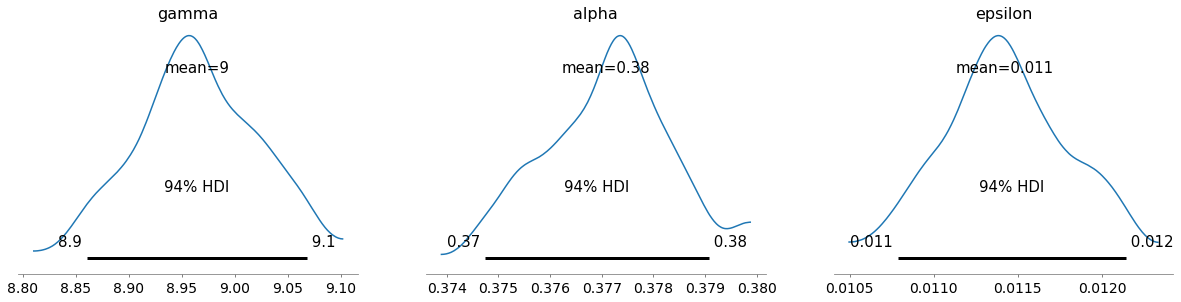

In [35]:
az.plot_posterior(trace, var_names=['gamma','alpha','epsilon'])

In [38]:
results = az.summary(trace, fmt='long')

In [39]:
def adjustment_df(results, source='MCMC', all_galaxy_params=all_galaxy_params): 
    adjustments = []
    for galaxy, gdf in results.groupby('Galaxy'):
        data = {'Galaxy': galaxy, 'Source': source}
        for param in all_galaxy_params:
            if param in gdf:
                data[param] = gdf[param]['mean']
                data['e_%s' % param] = gdf[param]['sd']
        adjustments.append(data)
    return pd.DataFrame(adjustments)

mcmc_adjs = adjustment_df(results)

KeyError: 'Galaxy'

In [40]:
first_mcmc = Result()#Result(adjustments=mcmc_adjs)

In [41]:
up = {}
for k in uni_params:
    up[k] = results.reset_index().query('index=="mean"')[k].mean()

In [42]:
# once you've done the adjustments via inputting it into a Results object
# this will update the mass ratios, R etc for us
# so can safely use here
T_force = null_gravity(first_mcmc.dataframe['Fnewton'], first_mcmc.dataframe['Fnulled'], **up)
first_mcmc.dataframe['Tgbar'] = T_force
first_mcmc.dataframe['log_Tgbar'] = np.log10(T_force)
first_mcmc.dataframe['Tbar'] = velocity(first_mcmc.dataframe['R'], T_force)
first_mcmc.idens=('V','W','T')

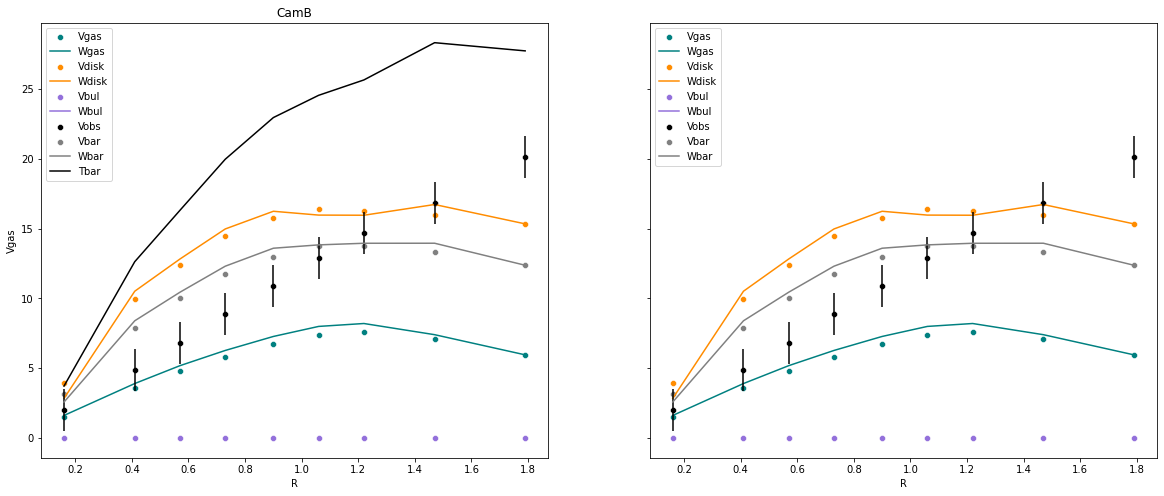

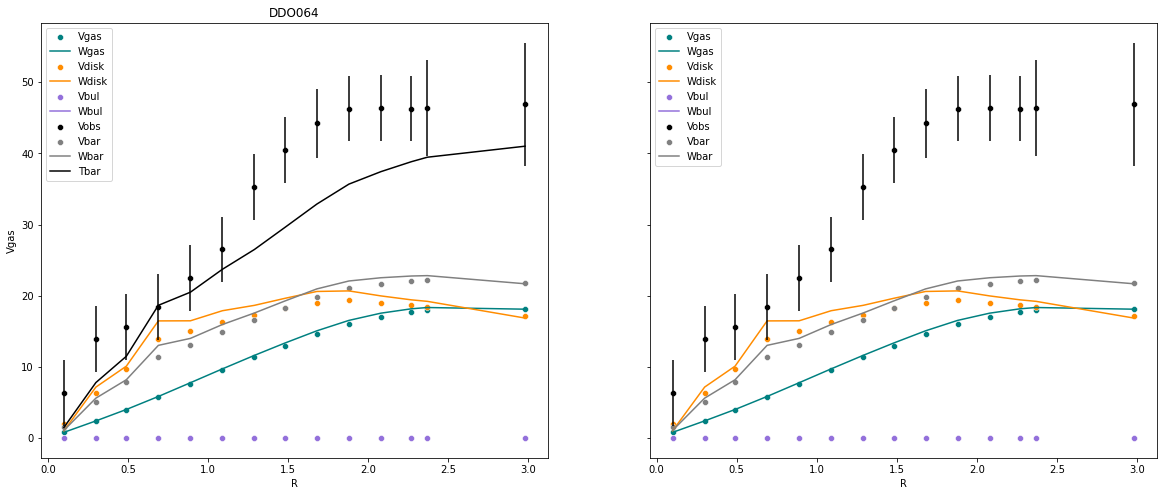

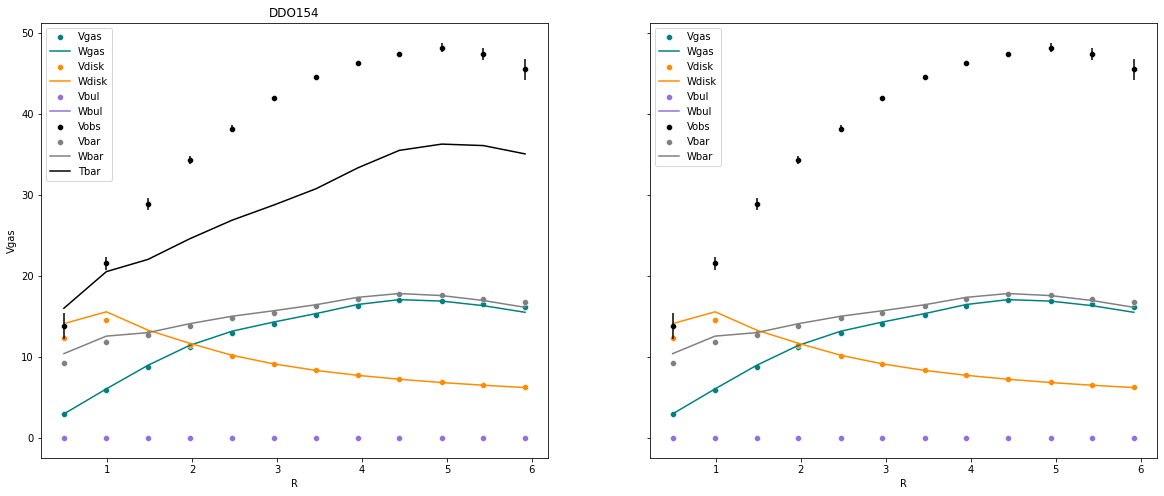

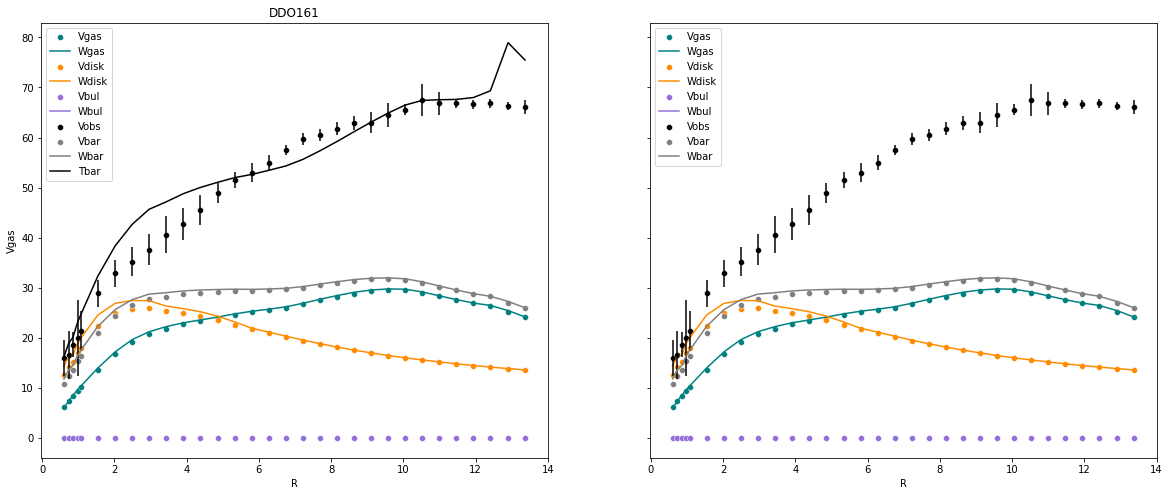

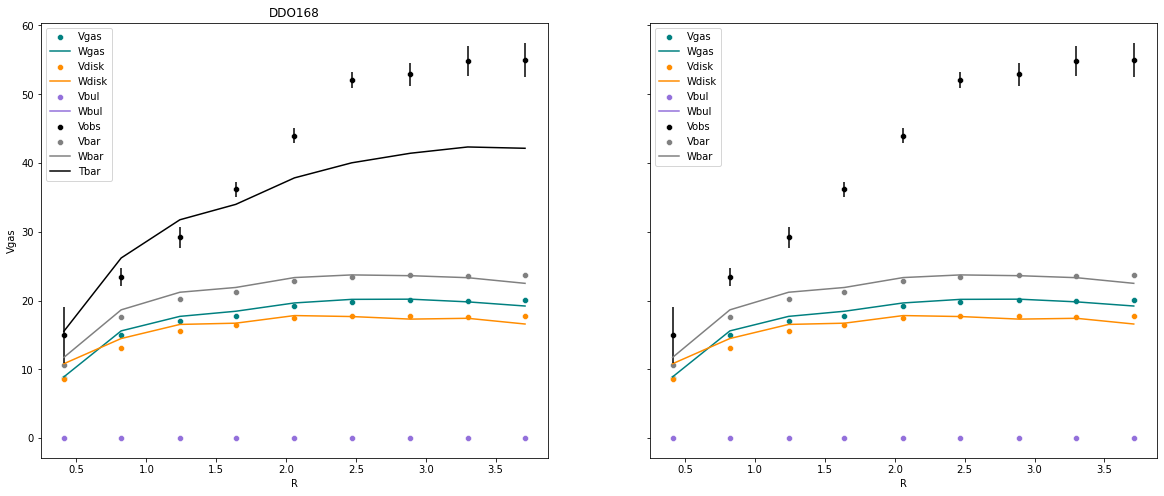

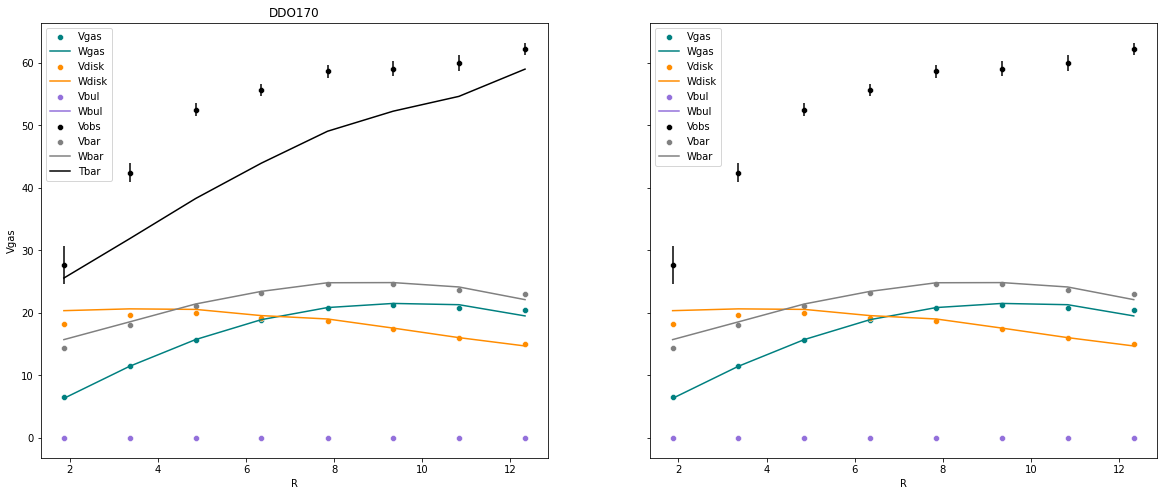

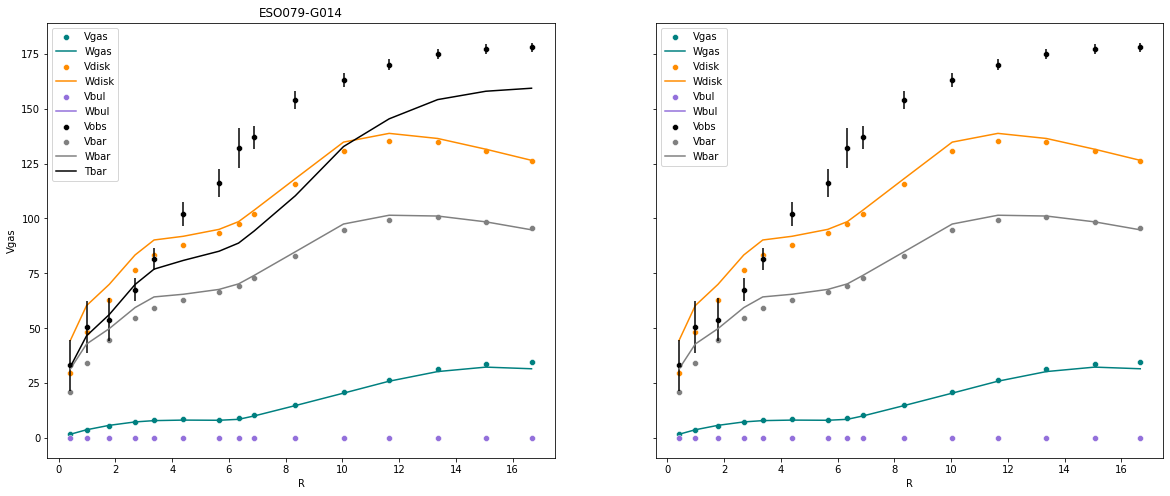

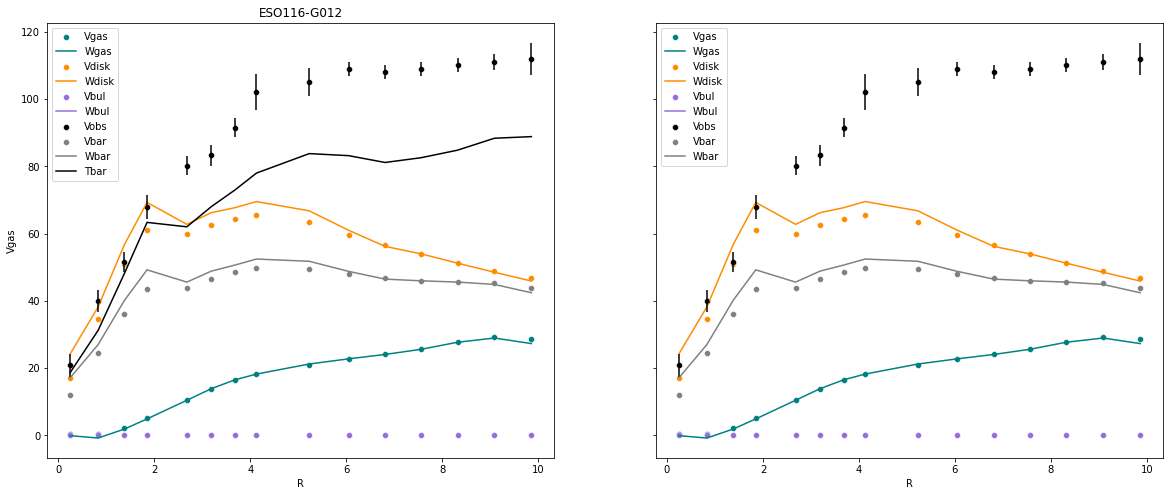

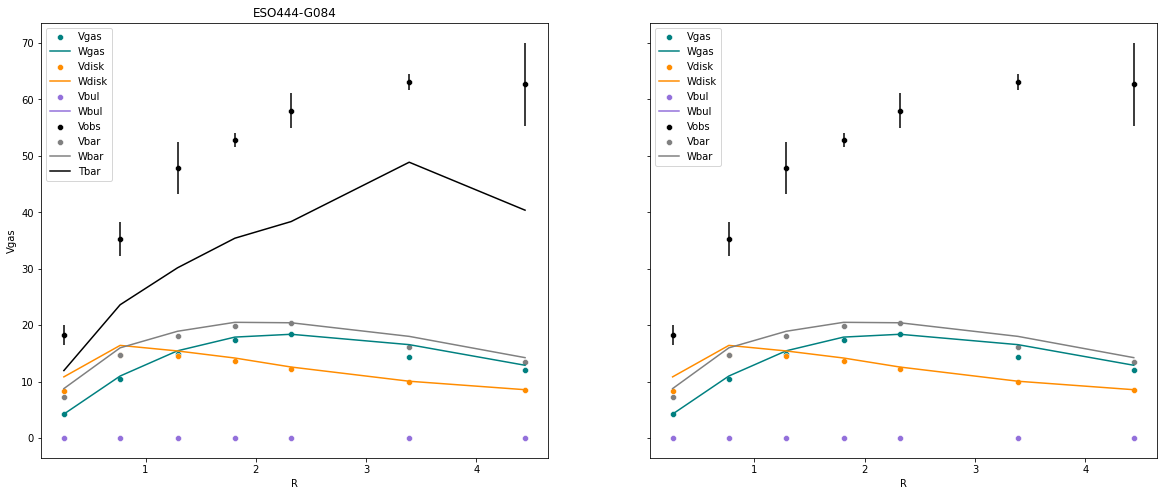

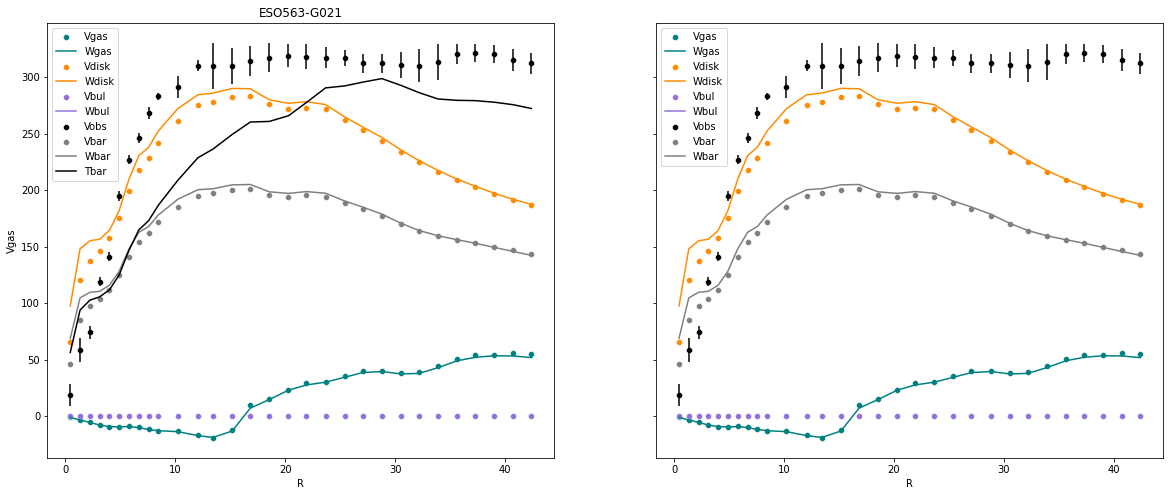

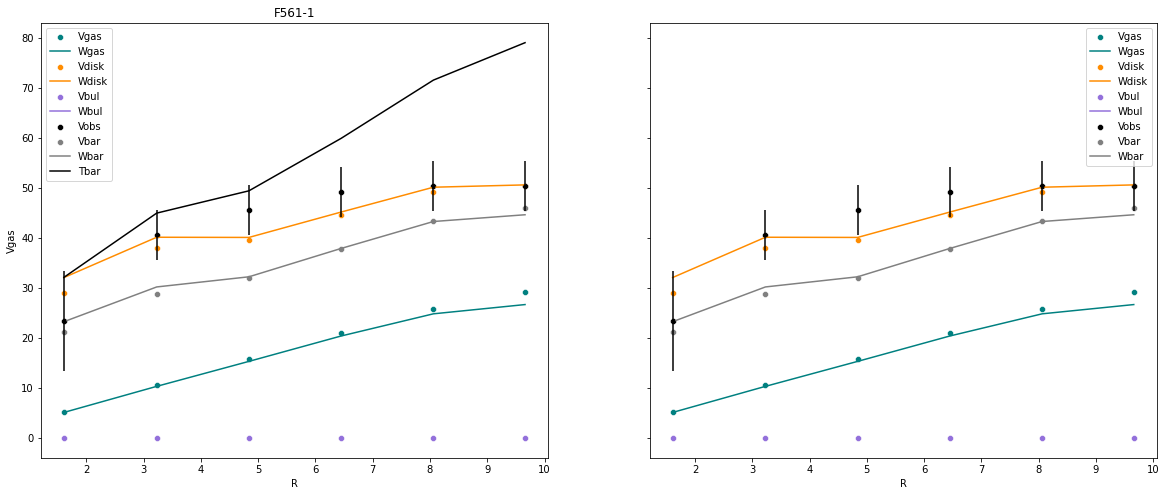

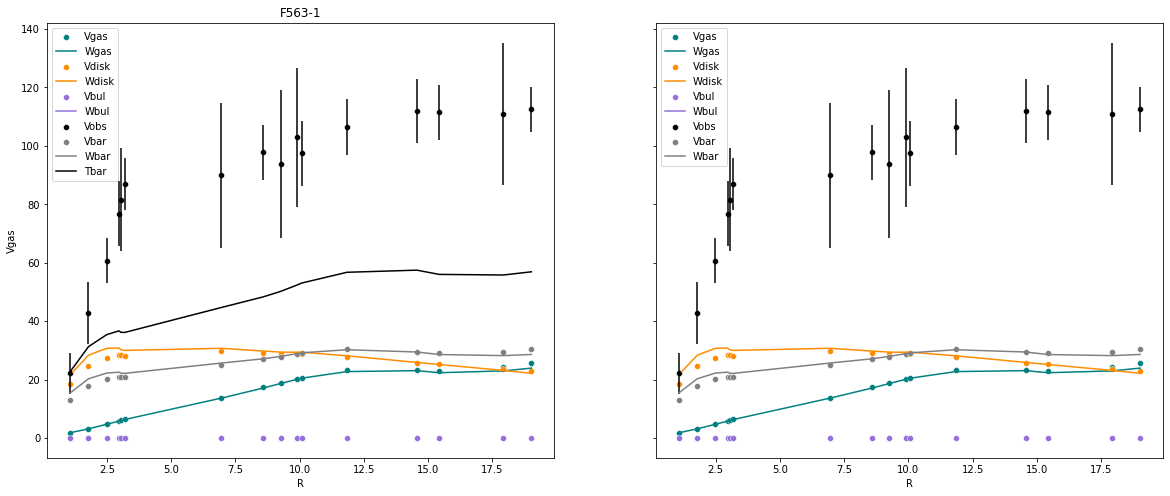

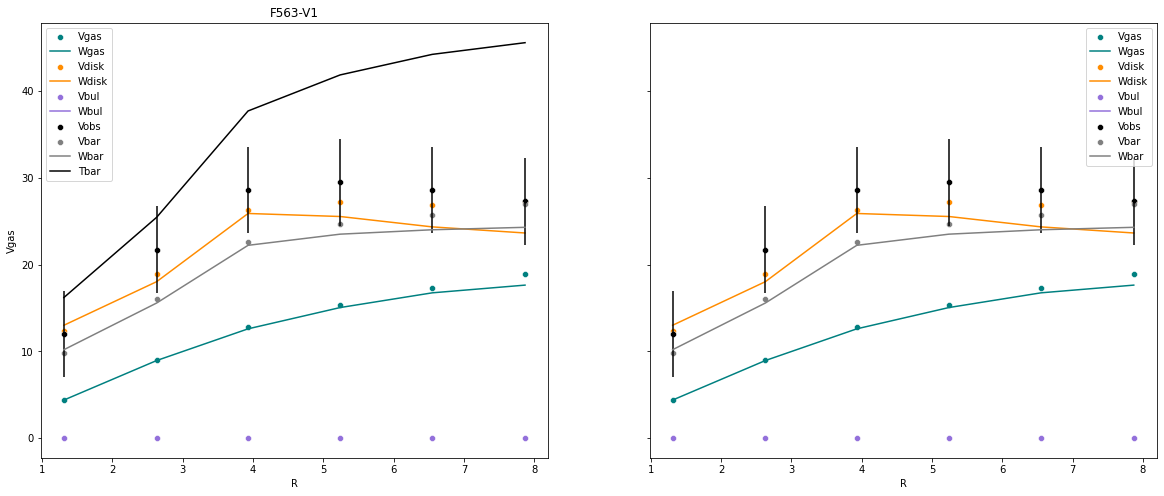

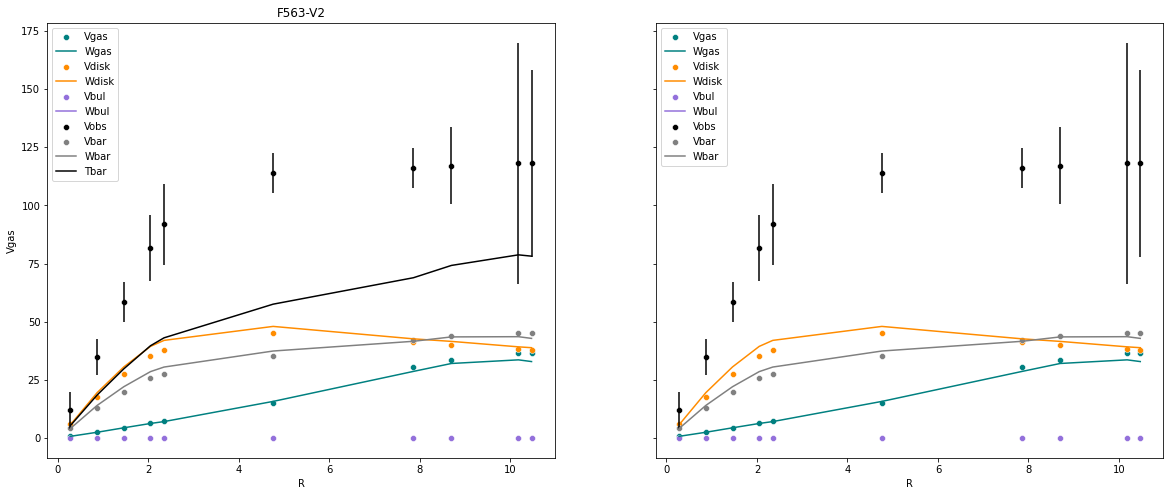

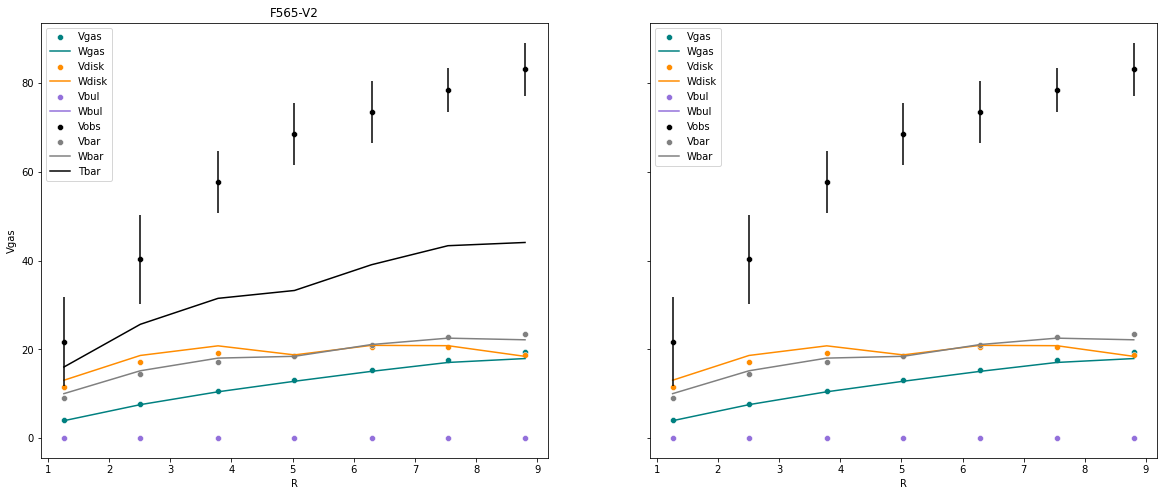

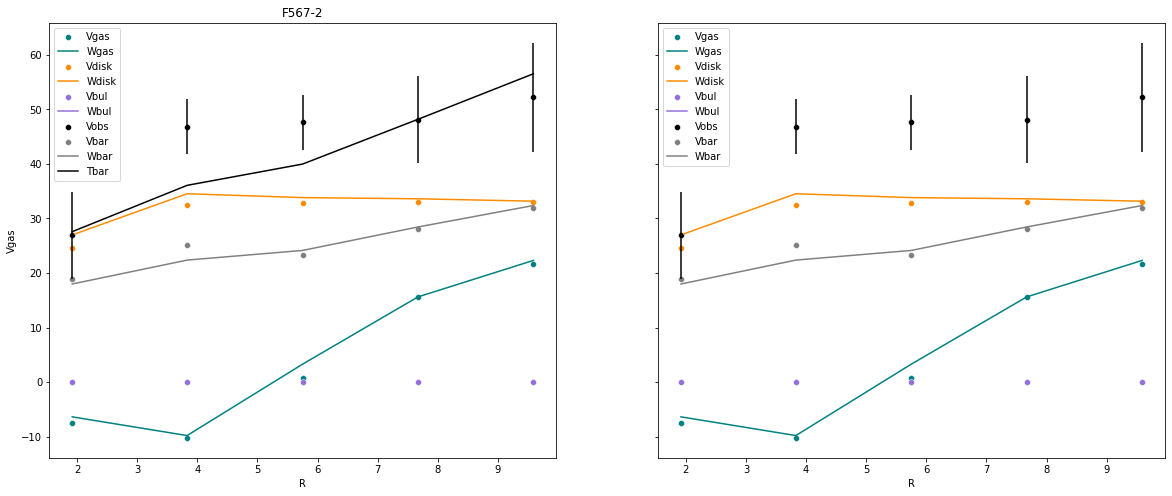

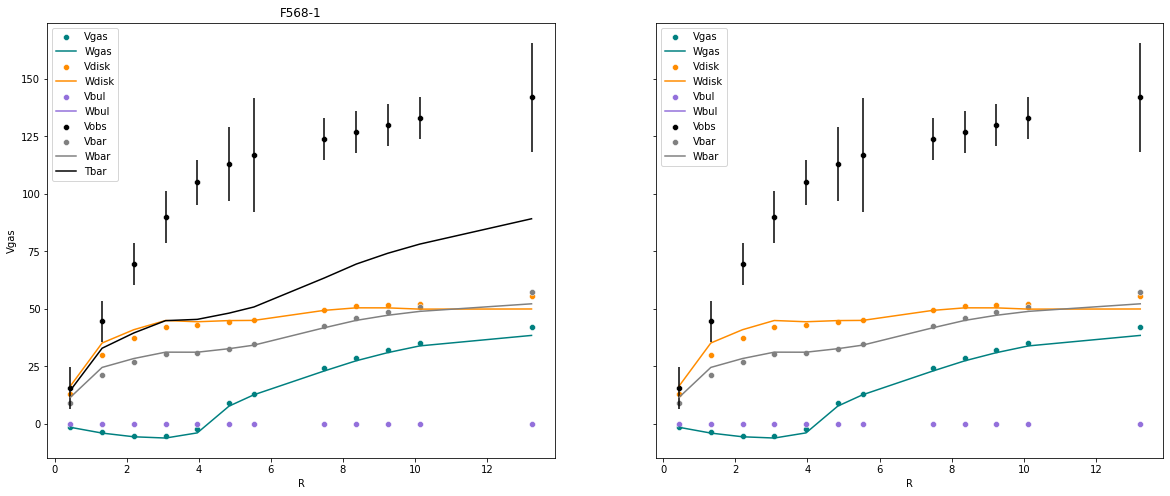

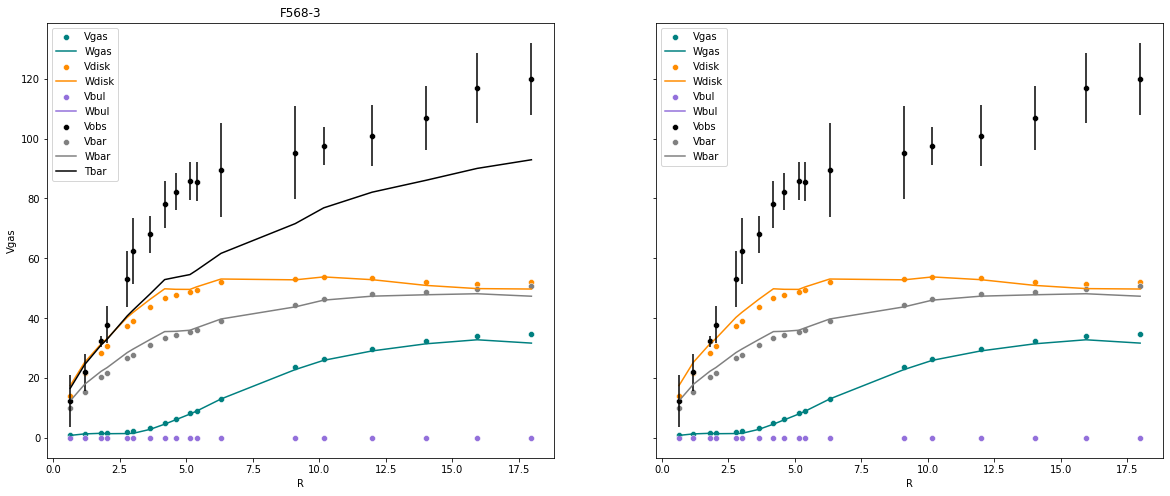

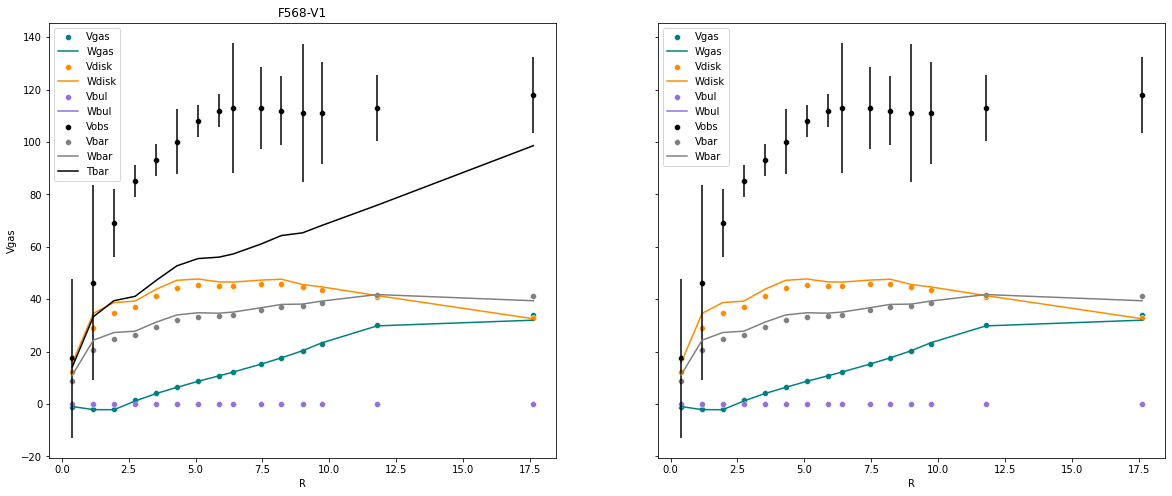

In [43]:
first_mcmc.plot_velocities(default, 20)

In [61]:
adjs = adjs[adjs['Galaxy'].isin(mcmc_adjs['Galaxy'])]
adjs = pd.concat([adjs,mcmc_adjs], ignore_index=True)

In [11]:
def plot_comparison(dfs, what_sources, compare, to_source='SPARC', sort=None, x_sort='Galaxy'):
    fig, axes = plt.subplots(3, 1, figsize=(20,10))
    
    # sort correctly
    to_df = dfs[dfs['Source']==to_source].sort_values(compare)
    indx = to_df.set_index(x_sort)
    indx['sort'] = np.arange(len(indx))
    
    for i, what_source in enumerate(what_sources):
        what_df = dfs[dfs['Source']==what_source]
        
        # 1. Absolutes
        ax = axes[0]
        
        # continue sort for both what's
        what_df = what_df.join(indx[['sort']], on=x_sort).sort_values('sort')
        
        # only plot reference once
        if i == 0:
            tx, ty, te = to_df[x_sort], to_df[compare], to_df["e_%s" % compare]
            ax.fill_between(tx, ty-2*te, ty+2*te, color='whitesmoke')
            ax.fill_between(tx, ty-te, ty+te, color='lightgrey')
            sns.lineplot(x=tx, y=ty, label=to_source, color='grey', ax=ax)
            sns.scatterplot(x=tx, y=ty, color='grey', ax=ax)
        
        color = ['teal', 'orange'][i]
        wx, wy, we = what_df[x_sort], what_df[compare], what_df["e_%s" % compare]    
        g = sns.scatterplot(data=what_df, x=wx, y=compare, label=what_source, ax=ax, color=color)
        g.errorbar(wx, wy, yerr=we, ecolor=color, fmt='.k', color=color)
        
        ax.set(xticklabels=[])
        
        # 2. Ratios
        ax = axes[1]
        yy = np.array(wy)/np.array(ty)
        if i == 0:
            ax.fill_between(tx, (ty-2*te)/ty, (ty+2*te)/ty, color='whitesmoke')
            ax.fill_between(tx, (ty-te)/ty, (ty+te)/ty, color='lightgrey')
        sns.scatterplot(x=tx, y=yy, ax=ax, color=color)
        ax.set(xticklabels=[])
        
        # 3. Histogram
        ax = axes[2]
        sns.histplot(yy, ax=ax, color=color)

